# Bird Sound Recognize

### Prepare Package

## Value Setting

In [ ]:
import os
import random
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Flatten, Dropout
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import json
import librosa
import librosa.display
import pickle
import itertools
from sklearn.metrics import confusion_matrix
from pathlib import Path

### Mount at Google Drive

In [ ]:
RUN_ONLINE = False
if RUN_ONLINE:
    from google.colab import drive

    drive.mount("/content/gdrive")
    PREFIX = Path("Gdrive path here")
else:
    PREFIX = Path("Local path here")

### Train Value

In [ ]:
SOUND_PATH = str(PREFIX / "dataset/raw")
DATASET_PATH = str(PREFIX / "dataset/Tyler_data")
WAV_PATH = r""

MODEL_NAME = "Model_test"

TIME_STEP = 20
SOUND_LENGTH = 128
TEST_DATA_RATIO = 0.3
INPUT_SHAPE = (TIME_STEP, SOUND_LENGTH)
CLASSES = [
    "before_net",
    "build_nest",
    "fail",
    "hug_egg",
    "out_nest",
    "spawn",
    "yu_zhu_qi",
]

MODEL_CONV1DS = [256, 0, 256]
MODEL_LAYERS_POW = [8, 7, 8, 9, 8]
MODEL_LAYERS = [512, 0, 128, 0, 64, 16]
BATCH_SIZE = 60
EPOCHS = 100

model = None

## Prepare All Tool

### Sound Proccess Tool

In [ ]:
def Numpy_Gaussian_noise(inputs, stdev):
    noise = stdev * np.random.normal(size = inputs.shape) 
    return inputs + noise

In [ ]:
class SoundProcessor:
    def __init__(self):
        self.data = []
        self.sr = None

    def load_sound(self, path):
        self.data, self.sr = librosa.load(path)
        return self.data

    def transform_mfcc(self, data):
        mfcc = librosa.feature.mfcc(y=data, sr=self.sr, n_mfcc=SOUND_LENGTH)
        arr = mfcc.T #分貝
        arr = arr[np.shape(arr)[0] % TIME_STEP:, :]
        return arr

    def plot_mfcc(self, data, save_path):
        arr = librosa.feature.mfcc(y=data, sr=self.sr, dct_type=3)
        arr = arr.T
        mfccArr = arr[np.shape(arr)[0] % TIME_STEP:, :]
        count = 0
        if mfccArr.shape[0] < TIME_STEP:
            print("Arr is too short, ignored.", mfccArr.shape)
            return
        for subArr in np.split(mfccArr, mfccArr.shape[0] // TIME_STEP):
            count += 1
            fig, ax = plt.subplots()
            img = librosa.display.specshow(subArr, ax=ax)
            fig.colorbar(img, ax=ax)
            fig.savefig(save_path[:-4] + f"_{count}.png")
            fig.clear()

    def bird_sound_all_classes_json(self, load_folder, save_path):
        if not os.path.exists(save_path):
            os.mkdir(save_path)
        for folder in os.listdir(load_folder):
            load_path = os.path.join(load_folder, folder)
            folderData = []
            for filename in os.listdir(load_path):
                if 'hack' in filename:
                    continue
                data = self.load_sound(os.path.join(load_path, filename))
                mfccArr = self.transform_mfcc(data)
                if mfccArr.shape[0] < TIME_STEP:
                    print(filename, "arr is too short, ignored.", mfccArr.shape)
                    continue
                for subArr in np.split(mfccArr, mfccArr.shape[0] // TIME_STEP):
                    # print("test")
                    # print(len(subArr[0]))
                    folderData.append(subArr.tolist())
                print(filename, " done.")
            split_idx = max(1, int(len(folderData) * TEST_DATA_RATIO))
            random.seed(8787)
            random.shuffle(folderData)
            test_arr = folderData[:split_idx]
            train_arr = folderData[split_idx:]
            # print(test_arr)
            # print(train_arr)
            filename = os.path.join(save_path, folder + ".json")
            with open(filename, "w") as f:
                print(np.array(test_arr).shape)
                print(np.array(train_arr).shape)
                data = {"test": test_arr, "train": train_arr}
                json.dump(data, f)
            print(folder + ".json", " saved.  \n", "Located: ", filename)

        print("Every folder have done!")
        print(f"Save at path: {save_path}")
        print("==================================================================================================")

    def bird_sound_all_classes_npy(self, load_folder, save_path):
        if not os.path.exists(save_path):
            os.mkdir(save_path)
        for folder in os.listdir(load_folder):
            load_path = os.path.join(load_folder, folder)
            folderData = []
            for filename in os.listdir(os.path.join(load_path)):
                data = self.load_sound(os.path.join(load_path, filename))
                mfccArr = self.transform_mfcc(data)
                if mfccArr.shape[0] < TIME_STEP:
                    print(filename, "arr is too short, ignored.", mfccArr.shape)
                    continue
                for subArr in np.split(mfccArr, mfccArr.shape[0] // TIME_STEP):
                    folderData.append(subArr)
                print(filename, " done.")
            split_idx = max(1, int(len(folderData) * TEST_DATA_RATIO))
            test_arr = folderData[:split_idx]
            train_arr = folderData[split_idx:]
            random.shuffle(folderData)
            test_npy_folder = os.path.join(save_path, "test")
            train_npy_folder = os.path.join(save_path, "train")
            if not os.path.exists(test_npy_folder):
                os.mkdir(test_npy_folder)
            if not os.path.exists(train_npy_folder):
                os.mkdir(train_npy_folder)
            test_npy_filename = os.path.join(test_npy_folder, folder + ".npy")
            train_npy_filename = os.path.join(train_npy_folder, folder + ".npy")
            np.save(test_npy_filename, np.asarray(test_arr))
            # print(test_arr)
            np.save(train_npy_filename, np.asarray(train_arr))
            print(test_npy_filename, "saved. length:", TIME_STEP, " x ", SOUND_LENGTH)
            print(train_npy_filename, "saved. length:", TIME_STEP, " x ", SOUND_LENGTH)

        print("Every folder have done!")
        print(f"Save at path: {save_path}")
        print("==================================================================================================")

    def hack_load_wav_into_json(self, load_folder, save_path):
        global now_hacking
        if not os.path.exists(save_path):
            os.mkdir(save_path)
        for c in now_hacking:
            folder = CLASSES[c]
            load_path = os.path.join(load_folder, folder)
            folderData = []
            for filename in os.listdir(load_path):
                if 'hack' in filename:
                    continue
                data = self.load_sound(os.path.join(load_path, filename))
                mfccArr = self.transform_mfcc(data)
                if mfccArr.shape[0] < TIME_STEP:
                    print(filename, "arr is too short, ignored.", mfccArr.shape)
                    continue
                for subArr in np.split(mfccArr, mfccArr.shape[0] // TIME_STEP):
                    # print("test")
                    # print(len(subArr[0]))
                    folderData.append(subArr.tolist())
                print(filename, " done.")
            split_idx = max(1, int(len(folderData) * TEST_DATA_RATIO))
            random.seed(8787)
            random.shuffle(folderData)
            test_arr = folderData[:split_idx]
            train_arr = folderData[split_idx:]
            # print(test_arr)
            # print(train_arr)
            filename = os.path.join(save_path, folder + ".json")
            with open(filename, "w") as f:
                print(np.array(test_arr).shape)
                print(np.array(train_arr).shape)
                data = {"test": test_arr, "train": train_arr}
                json.dump(data, f)
    def instant_transform(self, data):
        mfccArr = self.transform_mfcc(data)
        if mfccArr.shape[0] < TIME_STEP:
            print("Video is too short, can't recognize.")
            return np.array([])
        queue = [subArr for subArr in np.split(mfccArr, mfccArr.shape[0] // TIME_STEP)]
        return np.array(queue)

    def load_json(self, load_folder):
        x_train = []
        y_train = []
        x_test = []
        y_test = []
        y=0
        for y, c in enumerate(CLASSES):
            filename = c+'.json'
            assert os.path.exists(os.path.join(load_folder, "JSON", filename)), f'{os.path.join(load_folder, "JSON", filename)} doesn\'t exist'
            print(f'loading {filename}')
            load_path = os.path.join(load_folder, "JSON", filename)
            print(load_path)
            data = json.load(open(load_path))
            print(f"{filename} have loaded.")
            x_test += data["test"]
            x_train += data["train"]
            for i in range(len(data["test"])):
                y_test.append(y)
            for i in range(len(data["train"])):
                y_train.append(y)
            y+=1
        return np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)
    def hack_load_json(self, load_folder):
        global now_hacking
        x_train = []
        y_train = []
        x_test = []
        y_test = []
        y=0
        for c in now_hacking:
            filename = f"{CLASSES[c]}.json"
            path = Path(load_folder)/filename
            if not os.path.isfile(os.path.join(load_folder, filename)):
              continue
            print(f'loading {filename}')
            load_path = os.path.join(load_folder, filename)
            print(load_path)
            data = json.load(open(load_path))
            print(f"{filename} have loaded.")
            x_test += data["test"]
            x_test += data["train"]
            for i in range(len(data["test"])):
                y_test.append(y)
            for i in range(len(data["train"])):
                y_test.append(y)
            y+=1
        return np.array(x_test), np.array(y_test)
    def load_npy(self, load_folder):
        x_train = []
        y_train = []
        x_test = []
        y_test = []
        for y, filename in enumerate(os.listdir(os.path.join(load_folder, "NPY", "train"))):
            load_path = os.path.join(load_folder, "NPY", "train", filename)
            print(load_path)
            data = np.load(load_path, allow_pickle=True)
            print(f"{filename} have loaded, shape: ", data.shape)
            x_train += data.tolist()
            for i in range(data.shape[0]):
                y_train.append(y)

        for y, filename in enumerate(os.listdir(os.path.join(load_folder, "NPY", "test"))):
            load_path = os.path.join(load_folder, "NPY", "test", filename)
            print(load_path)
            data = np.load(load_path, allow_pickle=True)
            print(f"{filename} have loaded, shape: ", data.shape)
            x_test += data.tolist()
            for i in range(data.shape[0]):
                y_test.append(y)
        return np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)


    def plot_bird_sound_all_classes(self, load_folder, save_path):
        if not os.path.exists(save_path):
            os.mkdir(save_path)
        for folder in os.listdir(load_folder):
            if not os.path.exists(os.path.join(save_path, folder)):
                os.mkdir(os.path.join(save_path, folder))
            load_path = os.path.join(load_folder, folder)
            for filename in os.listdir(os.path.join(load_path)):
                path = os.path.join(save_path, folder, filename)
                data = self.load_sound(os.path.join(load_path, filename))
                self.plot_mfcc(data, path)
                print(folder + ".json", " have plot.  \n", "Located: ", path)

        print("Every figure have done!")
        print(f"Save at path: {save_path}")
        print("==================================================================================================")



### Model Create Tool

#### Classes TransForm

In [ ]:
def classes_change(mode):
    for i, C in enumerate(CLASSES):
        if i == mode:
            return C
    return "None"

#### Model Basic Functions

In [ ]:
def setting(model):
    model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
    return model

def fit(model, x_train, y_train, x_test, y_test, batch, epochs):
    y_train = to_categorical(y_train, 7)
    y_test = to_categorical(y_test, 7)
    print("START TRAINING==================================================================")
    train_history = model.fit(x=x_train, y=y_train,
                  validation_split=0.2,
                  epochs=epochs,
                  batch_size=batch,
                  verbose=2,
                  validation_data=(x_test, y_test),
                  shuffle=True,
                  )
    return model, train_history

def save(model, save_path, name):
    if not os.path.exists(save_path):
        os.mkdir(save_path)
    model.save(os.path.join(save_path, name+".h5"))
    print("Model have saved.")

def load(save_path):
    model = keras.models.load_model(save_path+".h5")
    model.summary()
    return model


#### Create Model

##### Conv1D Model

In [ ]:
def createConv1DModel(
        name,
        n_conv1Ds,
        n_layers,
        d_input,
        n_classes):
    """
    @param name: model name
    @param n_conv1Ds: filters of conv1D
    @param n_layers: filters of dense
    @param d_input: input shape
    @param n_classes: output classes
    @return: model
    """
    '''
    MODEL_CONV1DS = [256, 0, 256]
    MODEL_LAYERS = [512, 0, 128, 0, 64, 16]
    '''
    model = Sequential(name=f"{name}")
    model.add(Conv1D(128, kernel_size=3, input_shape=d_input, activation="relu", data_format = 'channels_first'))
    model.add(MaxPool1D(pool_size=2, data_format = 'channels_first'))
    for i in n_conv1Ds[1:]: #[C, M, D, C, M, / FC, D, FC, D, FC, FC/, FC]
        if i == 0:
            model.add(Dropout(0.2))
        else:
            model.add(Conv1D(i, kernel_size=3, activation="relu", data_format = 'channels_first'))
            model.add(MaxPool1D(pool_size=2, data_format = 'channels_first'))
    model.add(Flatten())
    for i in n_layers:
        if i == 0:
            model.add(Dropout(0.2))
        else:
            model.add(Dense(i, activation="relu"))
    model.add(Dense(len(n_classes), activation=None))
    model.summary()
    return model


#### Get model

In [ ]:
def get_model():
    return createConv1DModel("model",
                  MODEL_CONV1DS,
                  MODEL_LAYERS,
                  INPUT_SHAPE,
                  CLASSES,
                  )


#### Predict Function

In [ ]:
def predict_classes(model, data):
    prediction = [np.argmax(arr) for arr in model.predict(data)]
    predict_class = [classes_change(arr) for arr in prediction]
    return prediction, predict_class


#### Test Function

In [ ]:

def test(model, x_test, y_test, test_time=10):
    success = 0
    predictions, classes = predict_classes(model, x_test)
    for i in range(test_time):
        index = random.randint(0, len(x_test))
        predict = predictions[index]
        print(f"test{i+1}\t| prediction: ", classes[index], "\n     \t| answer: ", classes_change(y_test[index]))
        if predict == y_test[index]:
            print(f"Match\t| [ O ]")
            success += 1
        else:
            print(f"Match\t| [ X ]")
    print("Accuracy: ", success/test_time*100, "%.")


#### Plot Model's Accuracy & Loss

In [ ]:
def load_history(load_path, name):
    with open(os.path.join(load_path, name+"_history.p"), 'rb') as f:
        history = pickle.load(f)
    print("History have loaded")
    return history


def save_history(history, save_path, name):
  history = history.history
  if not os.path.exists(save_path):
    os.mkdir(save_path)
  with open(os.path.join(save_path, name+"_history.p"), 'wb') as f:
      pickle.dump(history, f)
  print("History have saved")


def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name, is_save=True, save_path=""):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''

    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))
    # Plot the Graph.
    fig = plt.figure()
    plt.plot(epochs, metric_value_1, 'blue', label=metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label=metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()
    plt.show()
    if not os.path.exists(save_path) and is_save:
      os.mkdir(save_path)

    if is_save and save_path != "":
      fig.savefig(save_path+".png")

def plot_all(model_training_history):
  plot_metric(model_training_history, "loss", "val_loss", "Train Loss Vs Train Val Loss",
        True, os.path.join(DATASET_PATH, "MODEL", MODEL_NAME + "_loss"))
  plot_metric(model_training_history, "accuracy", "val_accuracy", "Train Acc Vs Train Val Acc",
        True, os.path.join(DATASET_PATH, "MODEL", MODEL_NAME + "_acc"))

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [ ]:
def plot(history, save_path, name):
    if not os.path.exists(save_path):
        os.mkdir(save_path)
    print(history.history.keys())
    fig = plt.figure()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    fig.savefig(os.path.join(save_path, f"{name}_accuracy.png"))

    fig = plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    fig.savefig(os.path.join(save_path, f"{name}_loss.png"))


### Main wav proccess

In [ ]:
def main_wav_process(mode):
    soundTool = SoundProcessor()
    if mode == "npy":
        soundTool.bird_sound_all_classes_npy(SOUND_PATH, os.path.join(DATASET_PATH, "NPY"))
    elif mode == "json":
        soundTool.bird_sound_all_classes_json(SOUND_PATH, os.path.join(DATASET_PATH, "JSON"))

### Data Loader

In [ ]:
def data_loader(mode, path=DATASET_PATH):
    soundTool = SoundProcessor()
    x_train, y_train, x_test, y_test = [None]*4
    if mode == "npy":
        x_train, y_train, x_test, y_test = soundTool.load_npy(path)
    elif mode == "json":
        x_train, y_train, x_test, y_test = soundTool.load_json(path)
    elif mode == "hack":
        x_test, y_test = soundTool.hack_load_json(path)
    else:
        print("Please choice data type.")
        return
    return x_train, y_train, x_test, y_test

### Main Training


In [ ]:
def main_training(x_train, y_train, x_test, y_test, modelname):
    print("x_train: ", x_train.shape)
    print("y_train: ", y_train.shape)
    print("x_test: ", x_test.shape)
    print("y_test: ", y_test.shape)
    model = get_model()
    model = setting(model)
    model, history = fit(model,
                x_train, y_train,
                x_test, y_test,
                BATCH_SIZE,
                EPOCHS,
                )
    save(model, os.path.join(DATASET_PATH, "MODEL"), modelname)
    return model, history


### Main Plot
 

In [ ]:
def main_plot(history):
    plot_all(history)

In [ ]:
def main_confusion(x_test, y_test):
  y_predict = model.predict(x_test)
  y_pred = y_predict.argmax(axis=-1)
  one_hot_y_test = to_categorical(y_test)
  y_true = one_hot_y_test.argmax(axis=-1)
  target_names = CLASSES
  fig = plt.figure(figsize=(15, 15), dpi=100)
  cnf_martrix = confusion_matrix(y_true, y_pred)

  plot_confusion_matrix(cnf_martrix, classes=target_names, normalize=True,
                      title="bird sound recognize confusion matrix")
  plt.show()

  fig.savefig(f'{DATASET_PATH}/FIGURE/confusion_matrix_{MODEL_NAME}.png')

### Main Testing

In [ ]:
def main_testing(x_test, y_test):
    model = load(os.path.join(DATASET_PATH, "MODEL", MODEL_NAME))
    test(model, x_test, y_test, 150)

### Main Test wav


In [ ]:
def main_test_wav(wav_path):
    model = load(os.path.join(DATASET_PATH, "MODEL", MODEL_NAME))
    soundTool = SoundProcessor()
    data = soundTool.load_sound(wav_path)
    mfccData = soundTool.instant_transform(data)
    if mfccData.shape[0] != np.array([]).shape[0]:
        predictions, classes = predict_classes(model, mfccData)
        print("Prediction: ", max(classes))

### Main Get MFCC figure

In [ ]:
def main_mfcc_figure():
  soundTool = SoundProcessor()
  soundTool.plot_bird_sound_all_classes(SOUND_PATH, os.path.join(DATASET_PATH, "FIGURE"))

## RUN PLACE

In [ ]:
x_train, y_train, x_test, y_test = data_loader("json")

In [ ]:
min_loss = 100000000
max_acc = 0
each_epoch_loss = []
each_epoch_acc = []
best_loss_epoch = 0
best_acc_epoch = 0
for i in range(30, 31):
    EPOCHS = i
    model, history = main_training(x_train, y_train, x_test, y_test, MODEL_NAME)
    min_loss = min(min_loss, history.history["val_loss"][-1])
    max_acc = max(max_acc, history.history["val_accuracy"][-1])
    if min_loss == history.history["val_loss"][-1]:
        best_loss_epoch = i
    if max_acc == history.history["val_accuracy"][-1]:
        best_acc_epoch = i
    each_epoch_loss.append(history.history['val_loss'][-1])
    each_epoch_acc.append(history.history["val_accuracy"][-1])

print(f"\n\nThe minest loss is {min_loss} \t| It is at epoch {best_loss_epoch}")
print(f"The maxest acc is {max_acc} \t| It is at epoch {best_acc_epoch}")
print()
print(each_epoch_loss)
print(each_epoch_acc)

In [ ]:
save_history(history, os.path.join(DATASET_PATH, "HISTORY"), MODEL_NAME)

In [ ]:
main_plot(history)

In [ ]:
main_testing(x_test, y_test)

In [ ]:
main_confusion(x_test, y_test)

## Hack

目前加入的雜訊是平均值0標準差0.00005的常態分布資料到音檔裡，用audacity測量出大約是-85.88分貝，雖然沒有根據人類聽覺特別設計過雜訊，但還是幾乎沒有辦法分辨

在7個類別中，有五個類別在加了雜訊後

In [ ]:
LOAD_MODEL_FROM_FILE = True
if LOAD_MODEL_FROM_FILE:
  model = load(str(PREFIX/'dataset/Tyler_data/MODEL/Model_test'))#### you may want to change it
else:
  assert model != None

2022-07-07 20:49:23.303212: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-07 20:49:23.339449: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-07 20:49:23.339658: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-07 20:49:23.340168: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_14 (Conv1D)          (None, 128, 126)          7808      
                                                                 
 max_pooling1d_14 (MaxPoolin  (None, 128, 63)          0         
 g1D)                                                            
                                                                 
 dropout_21 (Dropout)        (None, 128, 63)           0         
                                                                 
 conv1d_15 (Conv1D)          (None, 256, 61)           98560     
                                                                 
 max_pooling1d_15 (MaxPoolin  (None, 256, 30)          0         
 g1D)                                                            
                                                                 
 flatten_7 (Flatten)         (None, 7680)              0     

In [ ]:
#hack edit wav
def Gaussian_noise_layer(inputs, std):
  noise = std * tf.random.normal(shape = inputs.get_shape(), mean = 0.0, stddev = 1, dtype = tf.float32) 
  return inputs + noise
def hack_wav(load_path:Path):
  for filename in load_path.glob("*.wav"):
    filename=str(filename)
    if 'hack' in filename:
      continue
    print(f'opening {filename}')
    audio_file = tf.io.read_file(filename)
    wave, sr = tf.audio.decode_wav(audio_file)
    wave = Gaussian_noise_layer(wave, 0.00005)
    audio_file = tf.audio.encode_wav(wave, sr)
    tf.io.write_file(filename.replace('.wav','-hack.wav'), audio_file)

In [ ]:
def hack_check(model, reload_wav, now_hacking):
  soundTool = SoundProcessor()
  if reload_wav:
    soundTool.hack_load_wav_into_json(SOUND_PATH, os.path.join(DATASET_PATH, "hack"))
  local_x_train, local_y_train, local_x_test, local_y_test = data_loader("hack", str(PREFIX/'dataset/Tyler_data/hack'))
  local_x_test = np.reshape(local_x_test, (-1, SOUND_LENGTH))
  local_x_test = local_x_test[5:]
  local_x_test = local_x_test[:local_x_test.shape[0]//TIME_STEP*TIME_STEP]
  local_x_test = np.reshape(local_x_test, (-1, TIME_STEP, SOUND_LENGTH))
  res = model.predict(local_x_test)
  print('res example:', res[:5])
  res = res[:,now_hacking]
  min = np.min(res)
  print(f'min precent: {min}')
  if min<0.1:
    return res, True
  else:
    print('ok, so sad')
    return res, False

In [ ]:
def plot_hack_hist(hist, title, save_path=None):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    bin_size=5
    ax.hist(hist, bins=range(0, 100+bin_size, bin_size))
    plt.title(title)
    plt.ylabel('Number of data')
    plt.xlabel('Accuracy (%)')
    plt.xlim(xmin=-10., xmax = 110.)
    plt.show()
    if save_path!=None:
      fig.savefig(str(save_path))

In [ ]:
def hack(reproduce_wav=False, reload_wav=True):
  global model, now_hacking
  for c in class_to_hack:
    now_hacking=[c]
    if reproduce_wav:
      hack_wav(PREFIX/f'dataset/raw/{CLASSES[c]}')
    res, end = hack_check(model, reload_wav, c)
    res *= 100
    plot_hack_hist(res, CLASSES[c], PREFIX/f"hack_result/{CLASSES[c]}.jpg")

class_to_hack = [2]
hack(True, True)

# Test with any file

In [ ]:
def test_with_selected_files(path, files, expected_class):
  for f in files:
    p=str(path/f)
    soundTool = SoundProcessor()
    data = soundTool.load_sound(p)
    mfccArr = soundTool.transform_mfcc(data)
    if mfccArr.shape[0] < TIME_STEP:
        print(p, "arr is too short, ignored.", mfccArr.shape)
        continue
    mfccArr = mfccArr[(np.random.choice(TIME_STEP)):]
    mfccArr = mfccArr[:mfccArr.shape[0] // TIME_STEP * TIME_STEP]
    global model
    test_data = []
    for subArr in np.split(mfccArr, mfccArr.shape[0] // TIME_STEP):
      test_data.append(subArr)
    test_data = np.array(test_data)
    res = model(test_data)
    print(res)
    res = res[:, expected_class]
    print(res)
    res *=100
    plot_hack_hist(res, f)

### read wav file and test

In [ ]:
test_with_selected_files(PREFIX/f'dataset/raw/{CLASSES[2]}', ['0001.wav', '0001-hack.wav'], 2)

## demo optimizer.minimize

In [ ]:
import tensorflow as tf
a = tf.Variable(tf.zeros((5), tf.float32))
opt = tf.keras.optimizers.Adam(learning_rate=0.01)

def f_a():
  return tf.reduce_sum((a-1)**2)
for i in range(400):
  opt.minimize(f_a, [a])
  print(i, a.numpy())

測試噪音聽感


In [ ]:
std = 5e-5
file = tf.audio.encode_wav(tf.random.normal((44100*100,1), stddev=std), 44100)
tf.io.write_file(str(PREFIX/f'noise{std}.wav'), file)

## add unperceivable noise to audio and see difference of mfcc result

In [ ]:
p=str(PREFIX/f'dataset/raw/{CLASSES[0]}/0000.wav')
soundTool = SoundProcessor()
data = soundTool.load_sound(p)
noised_data = Numpy_Gaussian_noise(data, 5e-5)
mfccArr = soundTool.transform_mfcc(data)
noised_mfccArr = soundTool.transform_mfcc(noised_data)
diff = np.reshape(abs(noised_mfccArr-mfccArr), (-1))

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.hist(diff, bins=1000)
plt.xlim(xmin=-0.5, xmax = 2)
plt.show()

print(f'mid: {np.median(diff)}')
print(f'min: {np.min(diff)}')
print(f'max: {np.max(diff)}')
print(f'mean: {np.mean(diff)}')

## decide to limit change to 0.2

## hack 2.0

In [ ]:
res = model(x_test)
res = res * to_categorical(y_test, 7)
res = tf.reduce_max(res, axis=1)
l = tf.argsort(res)
print(l[:10])

In [ ]:
l = np.random.choice(1929, (50), False)

In [ ]:
def choose_hack(to_hack):
  x_hack = x_test[to_hack]
  y_hack = to_categorical((y_test[to_hack]+1)%7, 7)
  return x_hack, y_hack

### Projected Gradient Descent

In [ ]:
def plot_hist(inputs):
  plt.hist(inputs, bins = 100)
  plt.show()
  print(f'mid: {np.median(inputs)}')
  print(f'min: {np.min(inputs)}')
  print(f'max: {np.max(inputs)}')
  print(f'mean: {np.mean(inputs)}')

In [ ]:
hack_result_PGD = []
for to_hack in l[:50]:
    print(f"now hacking {to_hack}")
    x_hack, y_hack = choose_hack(to_hack)
    noise_to_mfcc_data = tf.Variable(
        tf.keras.initializers.GlorotUniform()((1, TIME_STEP, SOUND_LENGTH))
    )
    opt = tf.keras.optimizers.Adam(learning_rate=5e-3)
    class tmp:
        def __init__(self, v=None):
            self.v = v

        def set(self, v):
            self.v = v

    loss_record = tmp()
    get_loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

    def loss_fn():
        x_new = x_hack + noise_to_mfcc_data
        global model
        y_predict = tf.reshape(model(x_new), (-1))
        loss = -get_loss(y_hack, y_predict)
        loss_record.set(loss)
        return loss

    constraint = 0.2
    last = 1000
    for i in range(100):
        opt.minimize(loss_fn, [noise_to_mfcc_data])
        noise_to_mfcc_data.assign(
            tf.clip_by_value(noise_to_mfcc_data, -constraint, constraint)
        )
        if i % 50 == 0:
            res = loss_fn()
            print(i, res.numpy())
    x_new = x_hack + noise_to_mfcc_data
    y_predict = tf.nn.softmax(tf.reshape(model(x_new), (-1)))
    print(f"acc:{y_predict[y_test[to_hack]].numpy()}")
    hack_result_PGD.append(y_predict[y_test[to_hack]].numpy())

now hacking 567
acc:0.15892121195793152
now hacking 1599
acc:0.006189380772411823
now hacking 1012
acc:0.9184435606002808
now hacking 918
acc:0.9097972512245178
now hacking 895
acc:0.0003219297796022147
now hacking 645
acc:0.9441558122634888
now hacking 449
acc:0.09076428413391113
now hacking 516
acc:0.05117999017238617
now hacking 762
acc:0.865360677242279
now hacking 1300
acc:0.001080856891348958
now hacking 923
acc:0.23942646384239197
now hacking 321
acc:0.8133878707885742
now hacking 657
acc:0.26030075550079346
now hacking 250
acc:0.15829236805438995
now hacking 329
acc:0.0005005456623621285
now hacking 627
acc:0.004438014701008797
now hacking 545
acc:0.15055407583713531
now hacking 266
acc:7.404840289382264e-06
now hacking 738
acc:0.0012403838336467743
now hacking 542
acc:2.2315637693282042e-07
now hacking 535
acc:0.7102530598640442
now hacking 511
acc:0.003999793436378241
now hacking 275
acc:6.633382554355194e-08
now hacking 613
acc:0.04614171385765076
now hacking 360
acc:0.01150

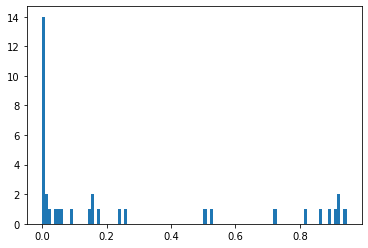

mid: 0.05151965096592903
min: 2.6619913384706706e-08
max: 0.9446098804473877
mean: 0.2560676038265228


In [ ]:
plot_hist(hack_result_PGD)

### Fast Gradient Sign Method

In [ ]:
hack_result_FGSM = []
for to_hack in l[:50]:
    x_hack, y_hack = choose_hack(to_hack)
    noise_to_mfcc_data = tf.Variable(tf.zeros((1, TIME_STEP, SOUND_LENGTH)), tf.float32)
    opt = tf.keras.optimizers.Adam(learning_rate=0.002)
    get_loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

    trainable_variables = [noise_to_mfcc_data]
    for _ in range(100):
        with tf.GradientTape() as t:
            x_new = x_hack + noise_to_mfcc_data
            y_predict = tf.reshape(model(x_new), (-1))
            loss = get_loss(y_hack, y_predict)

        gradients = tf.math.sign(t.gradient(loss, trainable_variables))
        opt.apply_gradients(zip(gradients, trainable_variables))

    x_new = x_hack + noise_to_mfcc_data
    y_predict = tf.nn.softmax(tf.reshape(model(x_new), (-1)))
    print(f"acc:{y_predict[y_test[to_hack]].numpy()}")
    hack_result_FGSM.append(y_predict[y_test[to_hack]].numpy())

acc:1.0926631821561728e-10
acc:0.9995672106742859
acc:0.9995779395103455
acc:0.9999864101409912
acc:0.2574045956134796
acc:0.9999021291732788
acc:0.9998332262039185
acc:0.9998989105224609
acc:0.9999665021896362
acc:0.9975754618644714
acc:0.9999927282333374
acc:0.9999959468841553
acc:0.9999957084655762
acc:0.9999885559082031
acc:0.9999957084655762
acc:0.9995085000991821
acc:0.9999994039535522
acc:0.9999997615814209
acc:0.9999852180480957
acc:1.0
acc:0.9999933242797852
acc:0.9999997615814209
acc:0.9999994039535522
acc:0.9999988079071045
acc:0.999993085861206
acc:0.9999998807907104
acc:1.0
acc:0.9999788999557495
acc:0.9999998807907104
acc:0.9999998807907104
acc:1.0
acc:0.9999821186065674
acc:0.9996169805526733
acc:0.9999996423721313
acc:0.9999998807907104
acc:1.0
acc:0.9999983310699463
acc:0.9999997615814209
acc:0.9998201727867126
acc:0.9999994039535522
acc:1.0
acc:1.0
acc:0.9999994039535522
acc:0.9999998807907104
acc:0.9999955892562866
acc:0.9999996423721313
acc:0.9999860525131226
acc:1.

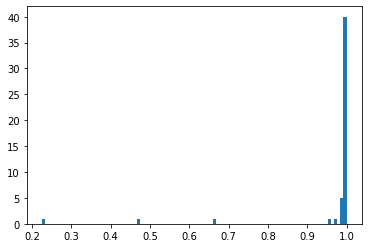

mid: 1.0
min: 0.22567811608314514
max: 1.0
mean: 0.964169442653656


In [ ]:
plot_hist(hack_result_FGSM)